# SC1015 Project Notebook 2

* [Importing Libraries and Dataset](#Importing-Libraries-and-Dataset)
* [Anomaly Detection with Isolation Forest](#Anomaly-Detection-with-Isolation-Forest)
    * [Running Isolation Forest on stroke alone](#if_alone)
    * [Running Isolation Forest on the entire dataset](#Running-Isolation-Forest-on-the-entire-dataset)
        * [1) Contamination 0.05](#c_05)
        * [2) Contamination 0.10](#c_10)
        * [3) Contamination 'auto'](#c_auto)
    * [Analysing the Results](#Analysing-the-Results)
        * [A) Looking at anomaly scores](#scores)
        * [B) Testing various anomaly score cutoffs](#cutoffs)
        * [C) Looking at the spread of anomaly scores](#spread)
* [Conclusion](#Conclusion)

---
#### Importing Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sb
sb.set()
import matplotlib.pyplot as plt 

In [3]:
# helper function to print markdown from python
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('&nbsp;' + string.replace('\n','<br>')))

In [4]:
mldata = pd.read_csv('mldata.csv')
mldata

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type__Govt_job,work_type__Private,work_type__Self-employed,work_type__children
0,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.3,1,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,1,0,0
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,80.0,1,0,1,1,83.75,28.3,0,0,1,0,0
5083,0,81.0,0,0,1,1,125.20,40.0,0,0,0,1,0
5084,0,35.0,0,0,1,0,82.99,30.6,0,0,0,1,0
5085,1,51.0,0,0,1,0,166.29,25.6,0,0,1,0,0


---
## Anomaly Detection with Isolation Forest 

The *unsupervised* **`Isolation Forest`** Machine Learning Model can be used to detect anomalies efficiently. It is based on the Random Forest Model, whereby a forest of random decision trees is generated and grown randomly. At each node, the model will select a feature to make a split, just like regular decision trees. The data continues to split until a lot of leaf nodes are generated. After this, the idea that anomalies are far away from other data points and can be isolated in fewer steps (shallow branches) is used to identify anomalies.

---
### Running Isolation Forest on `stroke` alone <a id='if_alone'></a>

In [5]:
from sklearn.ensemble import IsolationForest

In [6]:
# Fit Isolation Forest on stroke
model=IsolationForest(random_state=1)
model.fit(mldata[['stroke']])
print(model.get_params())

{'bootstrap': False, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [7]:
# Predict the model on stroke and make new DataFrame with the anomaly scores
ifdata = mldata.copy()
ifdata['is_anomaly'] = model.predict(mldata[['stroke']])
ifdata.is_anomaly = ifdata.is_anomaly.map({1:0, -1:1}) # Isolation forest gives 1 for normal and -1 for anomaly. 0, 1 instead is more natural
ifdata.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type__Govt_job,work_type__Private,work_type__Self-employed,work_type__children,is_anomaly
0,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,1
1,0,61.0,0,0,1,0,202.21,28.3,1,0,0,1,0,1
2,1,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0,1
3,0,49.0,0,0,1,1,171.23,34.4,1,0,1,0,0,1
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,1


In [8]:
ifdata.is_anomaly.value_counts()

0    4838
1     249
Name: is_anomaly, dtype: int64

`stroke` has `249` anomalies. We know that there are `249` positive stroke events, but we can still check to confirm.

In [9]:
len(mldata[(ifdata.is_anomaly == 1) & (ifdata.stroke == 1)])

249

Running `Isolation Forest` on `stroke` alone revealed that all positive stroke events are indeed anomalies, and this was expected because the percentage of positive `stroke` events is very less (`4.89%`). However, it is definitely not meaningful to run `Isolation Forest` on `stroke` alone since the model will only be using the `stroke` variable on  itself, which would mean all outliers are considered as anomalies. 

---
### Running Isolation Forest on the entire dataset
Instead, we should be running `Isolation Forest` on the entire dataset to get a good model and more robust anomaly identification. `Isolation Forest` is very sensitive to the `contamination` parameter. This parameter tells the model how many `outliers` are there in the dataset. The higher the contamination the more likely it is to categorise data as anomalies.

We are going to run this model and evaluate it with **3** different contamination values: <br>
1) `0.05` : There are `4.89%` of positive stroke events, so assuming they are all anomalies, we are passing a safe value of `5.00%` <br>
2) `0.10`: This was previously the default contamination value and it will be interesting to see how different the model behaves with this value. <br>
3) `auto`: This is the current default contamination value.

In [10]:
def isolation_forest(contamination,random_state):
    # Make new copy and run Iforest 
    ifdata = mldata.copy()
    model = IsolationForest(random_state=random_state,contamination=contamination)
    model.fit(mldata)
    
    # Add columns to copied DataFrame
    ifdata["is_anomaly"] = pd.Series(model.predict(mldata))
    ifdata["anomaly_score"] = pd.Series(abs(model.score_samples(mldata)))    
    
    # Change Anomaly Mapping (1 -> 0 -> Not An Anomaly, -1 -> 1 -> Is An Anomaly)
    ifdata.is_anomaly = ifdata.is_anomaly.map({1: 0, -1: 1})
    
    # Print overall stats
    counts = ifdata.is_anomaly.value_counts()
    printmd('**is_anomaly Stats**')
    print('Normal -', counts[0])
    print('Anomalies -', counts[1])
    print('Total Anomaly Percentage - {:.2f}%'.format((counts[1]/len(ifdata.is_anomaly) * 100)))
    
    printmd('**Barplots**')
    fig, (normplot, anomplot, strokeplot) = plt.subplots(3,1,figsize=(6,18))
    
    # Prepare data for normal values
    norm = ifdata[ifdata.is_anomaly==0].stroke.value_counts()
    norm_total = norm[0] + norm[1]
    norm_percents = [ 100 * norm[0]/norm_total, 100 * norm[1]/norm_total ]

    # Draw barplot
    sb.barplot(x=['No Stroke', 'Had Stroke'], y=norm_percents, ax=normplot)
    normplot.set(ylim=(0, 100))
    normplot.set(ylabel="Percentage of Total Normal values (%)")

    # Add percentage on top of bar
    for x in range(0,2):
        normplot.text(x,norm_percents[x] + 1, '{}'.format(norm[x]), color='black', ha="center")

    # Prepare data for abnormal values
    anom = ifdata[ifdata.is_anomaly==1].stroke.value_counts()
    anom_total = anom[0] + anom[1]
    anom_percents = [ 100 * anom[0]/anom_total, 100 * anom[1]/anom_total ]

    sb.barplot(x=['No Stroke', 'Had Stroke'], y=anom_percents, ax=anomplot)
    anomplot.set(ylim=(0, 100))
    anomplot.set(ylabel="Percentage of Total Anomalies (%)")

    # Add percentage on top of bar
    for x in range(0,2):
        anomplot.text(x,anom_percents[x] + 1, '{}'.format(anom[x]), color='black', ha="center")
    
    # Prepare data for abnormal values in context of the stroke variable 
    stroke_totals = [ norm[0] + anom[0], norm[1] + anom[1] ]
    stroke_anom_percents = [ 100 * anom[0]/stroke_totals[0], 100 * anom[1]/stroke_totals[1] ]

    sb.barplot(x=['No Stroke', 'Had Stroke'], y=stroke_anom_percents, ax=strokeplot)
    strokeplot.set(ylim=(0, 100))
    strokeplot.set(ylabel="Percentage of Anomalies (%)")

    # Add percentage on top of bar
    for x in range(0,2):
        strokeplot.text(x,stroke_anom_percents[x] + 1, '{:.2f}%'.format(stroke_anom_percents[x]), color='black', ha="center")
    
    plt.show()
    
    return ifdata

---
<a class="anchor" id="c_05"></a>
#### 1) Contamination 0.05

&nbsp;**is_anomaly Stats**

Normal - 4832
Anomalies - 255
Total Anomaly Percentage - 5.01%


&nbsp;**Barplots**

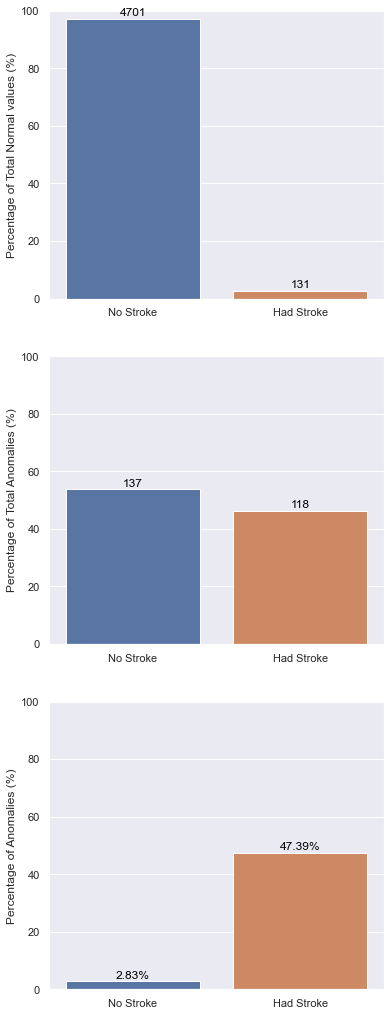

In [11]:
c_05 = isolation_forest(0.05,17);

A `contamination` value of `0.05` led to `5.01%` of the data being identified as anomalies. Out of this, `No stroke` accounts for more than half of all anomalies whereas only `118` out of `249` positive stroke events have been identified as anomalies. `No stroke` represents more than `95%` of all normal values whereas the remaining `131` positive stroke events are considered to be normal. In regards to `stroke` however, `2.83%` of all `No Stroke` values are anomalies in comparison to `47.38%` of all stroke events being anomalies.  

---
<a class="anchor" id="c_10"></a>
#### 2) Contamination 0.10

&nbsp;**is_anomaly Stats**

Normal - 4578
Anomalies - 509
Total Anomaly Percentage - 10.01%


&nbsp;**Barplots**

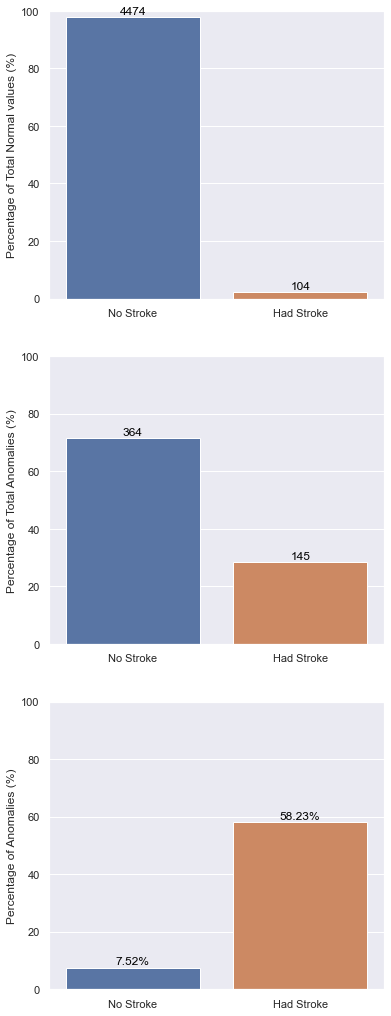

In [12]:
c_10 = isolation_forest(0.1,18);

A `contamination` value of `0.10` led to `10.01%` of the data being identified as anomalies. Out of this, `No stroke` accounts for around `70%` of all anomalies whereas only `145` out of `249` positive stroke events have been identified as anomalies. `No stroke` represents a slightly higher amount of all normal values than before whereas the number of positive stroke events considered to be normal has gone down to `104`. In regards to `stroke` however, `7.83%` of all `No Stroke` values are anomalies in comparison to `58.23%` of all stroke events being considered anomalies.  

---
<a class="anchor" id="c_auto"></a>
#### 3) Contamination 'auto'

&nbsp;**is_anomaly Stats**

Normal - 2913
Anomalies - 2174
Total Anomaly Percentage - 42.74%


&nbsp;**Barplots**

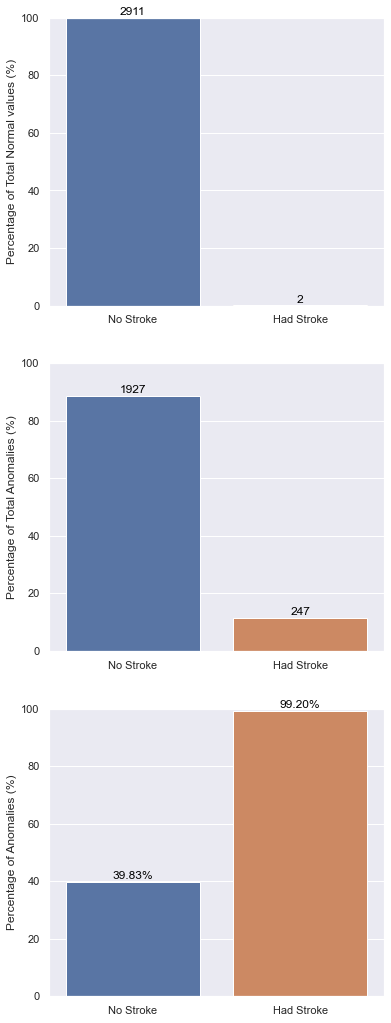

In [13]:
c_auto = isolation_forest('auto',19);

A `contamination` value of `auto` led to `42.74%` of the data being identified as anomalies. Out of this, `No stroke` accounts for more than `85%` of all anomalies whereas most of the positive stroke events have now been identified as anomalies. `No stroke` represents a slightly higher amount of all normal values than before whereas the number of positive stroke events considered to be normal has gone down to only `2`. In regards to `stroke` however, `39.83%` of all `No Stroke` values are anomalies in comparison to `99.20%` of all stroke events being considered anomalies.

---
### Analysing the Results

The `contamination` value of `Isolation Forest` helps the model decide how much of the data should be identified as anomalous. As the `contamination` value increased, the total amount of anomalies increased as well, and we saw the percentage of `No stroke` values accounting for total anomalies, as well as the percentage of anomalous `No stroke` values both increase. Similarly, the number of positive stroke values identified as outliers increased too with an increase in contamination. We saw it go from just `118` to more than a double of `247`, accounting for `99.20%` of all positive stroke values being anomalies. 

But what does it mean for us? Which contamination value is more reliable? To answer that, we must first look at the anomaly scores given to each positive stroke event by `Isolation Forest`

-----
<a class="anchor" id="scores"></a>
#### A) Looking at anomaly scores

In [14]:
def get_score_list(ifdata):
    scorelist = list(ifdata[(ifdata.stroke==1)].anomaly_score)
    scorelist = [round(x,2) for x in scorelist] 
    return sorted(set(scorelist))

In [15]:
printmd('**Contamination Value 0.05**')
print(get_score_list(c_05))

&nbsp;**Contamination Value 0.05**

[0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.7, 0.71, 0.72]


In [16]:
printmd('**Contamination Value 0.10**')
print(get_score_list(c_10))

&nbsp;**Contamination Value 0.10**

[0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71]


In [17]:
printmd("**Contamination Value 'auto'**")
print(get_score_list(c_auto))

&nbsp;**Contamination Value 'auto'**

[0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.71]


The set of unique `anomaly` scores is very similar for all `3` contamination values. Most of them lie within the range of `0.5` to `0.7`. The closer a score is to `1`, the more likely it is an anomaly. Scores less than `0.5` are generally considered as normal data values. So it isn't a matter of tuning the `contamination` value, but rather deciding the `score` cutoff. 

---
<a class="anchor" id="cutoffs"></a>
#### B) Testing various anomaly score cutoffs
Let's take the `ifdata` DataFrame for the first model with `contamination 0.05` last model with `contamination 'auto'` and see how many positive stroke events are considered as anomalies with different `score` cutoffs. 

In [18]:
printmd('**Contamination 0.05**')
for cutoff in [ 0.5, 0.6, 0.7 ]:
    print("Cutoff {}:\t{}".format(cutoff,len(c_05[(c_05.stroke==1) & (c_05.anomaly_score > cutoff)])))
    
printmd("**Contamination 'auto'**")
for cutoff in [ 0.5, 0.6, 0.7 ]:
    print("Cutoff {}:\t{}".format(cutoff,len(c_auto[(c_auto.stroke==1) & (c_auto.anomaly_score > cutoff)])))

&nbsp;**Contamination 0.05**

Cutoff 0.5:	249
Cutoff 0.6:	122
Cutoff 0.7:	4


&nbsp;**Contamination 'auto'**

Cutoff 0.5:	247
Cutoff 0.6:	109
Cutoff 0.7:	2


This clearly shows us that the `anomaly scores` aren't affected much by the `contamination` value. It is likely that the cutoff for `contamination 0.05` was more than `0.6`, which is why only `118` stroke events were considered an anomaly in comparison to `contamination 'auto'` which most likely had a cutoff at `0.5`. 

---
<a class="anchor" id="spread"></a>
#### C) Looking at the spread of anomaly scores

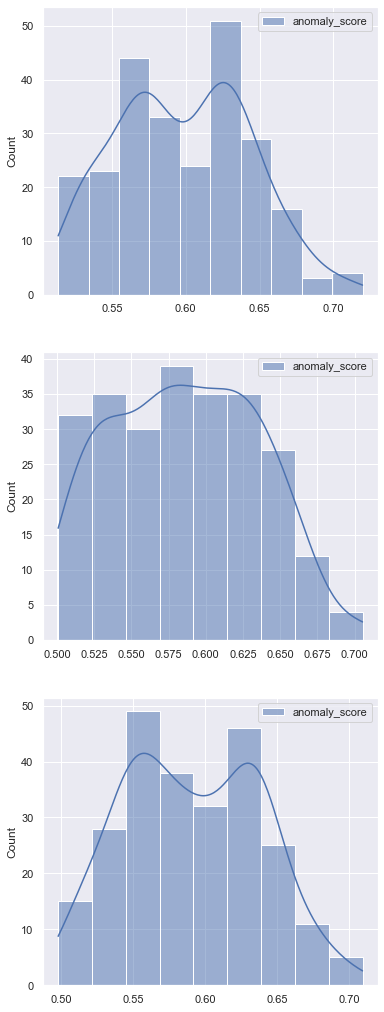

In [19]:
fig, ax = plt.subplots(3,1,figsize=(6,18))
sb.histplot(data=pd.DataFrame(c_05[c_05.stroke == 1].anomaly_score),kde=True,ax=ax[0])
sb.histplot(data=pd.DataFrame(c_10[c_10.stroke == 1].anomaly_score),kde=True,ax=ax[1])
sb.histplot(data=pd.DataFrame(c_auto[c_auto.stroke == 1].anomaly_score),kde=True,ax=ax[2]);

These `3` histplots with kde show that even the distribution of `anomaly_score` is very similar across different `contamination` values. 

---
### Conclusion

In [20]:
display(pd.DataFrame(c_auto[c_auto.stroke == 1].anomaly_score).describe())
printmd('**Median** - {:.4f}'.format(pd.DataFrame(c_auto[c_auto.stroke == 1].anomaly_score).median().values[0]))

,anomaly_score
count,249.000000
mean,0.591057
std,0.047588
min,0.497757
25%,0.551904
50%,0.589451
75%,0.631925
max,0.709460


&nbsp;**Median** - 0.5895

---
Along with the previous analysis and a mean and median of around `0.59` and a standard deviation of `0.05`, it is safe to say that having a `stroke` is highly likely to always be an anomaly. However, since most of the data points lie within this range, around an anomaly score of `0.60`, we can still try to run some prediction models to gain more insight into positive `stroke` events. 